### An exploration of Transfer Entropy

Finding causality in systems is often the goal in the field of data-driven dynamics. Granger causality is the most famous measure of causality but it is known to have problems capturing nonlinear behaviour. We explore Transfer Entropy (TE) as a measure of causality in various kinds of systems after some inspiration from [1] where it shows collective behaviour and directionality of causation.


There are some open-source software to measure TE, granger causality etc:
1. The Information Dynamics Toolkit xl (IDTxl) - https://github.com/pwollstadt/IDTxl
2. Java Information Dynamics Toolkit (JIDT) - https://github.com/jlizier/jidt

Both these codebases are comprehensive. However, crucial underlying functions are written in Java. Although they can be used in Python using JPype, there are so many issues between JPype and the .jar file in the codebases that I wasn't able to run it after a lot of effort.

This notebook has code for Transfer Entropy only for discrete systems. We do explore some continuous systems but we discretize them to integers and that has its shortcomings. For continuous systems, I would reccomend getting the earlier software to work. Some of the code below might not work if you don't have the latest version of pandas

#### References

1. Razak, Fatimah Abdul, and Henrik Jeldtoft Jensen. "Quantifying ‘causality’in complex systems: understanding transfer entropy." PLoS One 9.6 (2014): e99462.




In [1]:
from numba import jit

/home/jithin/anaconda3/lib/python3.6/site-packages/numba/errors.py:105: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt

The Transfer Entropy function

In [3]:
def TE(X,X_1,Y):
    '''
    Input:
        Takes times series X, X_1 (Which is X one step before)and Y
    Output:
        ans  - Measure of how 
        Joint Distribution of X,X_1 and Y
        Conditional Distribution of X given X_1
        Conditional Distribution of X given X_1 and Y
    '''
    if len(X) != len(X_1):
        print('Lengths of X and X_1 dont match')
    elif len(X) != len(Y):
        print("Lengths of X and Y dont match")
    m  = [np.random.randint(-10,-5) for i in range(len(X))]
    df = pd.DataFrame({'X':X,'X_1':X_1, 'Y':Y, 'm':m})
    States_X = list(set(X))
    States_X_1 = list(set(X_1))
    States_Y = list(set(Y))
    JointDist = df.groupby(['X', 'X_1','Y']).count()/len(df) 
    JointDist = JointDist.reorder_levels(['X','X_1','Y']).sort_index()
    DistXgivenX_1 = (df.groupby(['X','X_1']).count() / df.groupby(['X_1']).count())
    DistXgivenX_1 =DistXgivenX_1.reorder_levels(['X','X_1']).sort_index()
    
    countto = lambda x: x / x.count()
    DistXgivenX_1Y = df.groupby(['X','X_1','Y']).count().groupby(['X_1','Y']).transform(countto)
                          
    DistXgivenX_1Y = DistXgivenX_1Y.reorder_levels(['X','X_1','Y']).sort_index()
    ans = 0
    for  x in States_X:
        for y in States_Y:
            for z in States_X_1:
                #print(x,z,y)
                #print(JointDist.loc[x,z,y]['m'])
                try:
                    #print('Joint Dist :'+ str(JointDist.loc[x,z,y]['m']))
                    #print(' Dist 1 :'+ str(DistXgivenX_1Y.loc[x,z,y]['m']))
                    #print(' Dist 2:'+ str(DistXgivenX_1.loc[x,z]['m']))
                    f = JointDist.loc[x,z,y]['m']*np.log(DistXgivenX_1Y.loc[x,z,y]['m']/DistXgivenX_1.loc[x,z]['m'])
                    #print(f)
                    #print('E:' +str( f))
                    #print(JointDist.loc[x,z,y]['m'],DistXgivenX_1Y.loc[x,z,y]['m'],DistXgivenX_1.loc[x,z]['m'])
                    ans += f
                    #print(ans)
                except:
                    pass
    return ans,JointDist,DistXgivenX_1,DistXgivenX_1Y
    

#### A test

In [4]:
X = [-1,0 ,0, -1,0,-1,-1,0]
Y =  [np.random.randint(3,5) for i in range(8)]
X_1 =  [1,1,2,2,2,1,1,2]
ans, JD, MD, PD =TE(X,X_1,Y)
JD

m
X  X_1 Y       
-1 1   3  0.250
       4  0.125
   2   4  0.125
 0 1   3  0.125
   2   3  0.375

#### A Markov Chain

Here, we simulate a Hidden Markov Model. The Markov Chain describes the weather which could change between 'Rainy' and 'Sunny' or not change. Depending on the weather, people can decide to either 'walk', 'shop' or 'clean' with various probabilities. That creates a parallel chain of tasks. The code belows simulates the weather and the tasks.

We collect the simulated series and use transfer entropy to measure how much the weather influenced the task. With this code, we also incorporated delay. For example, if the lag was 3, people would decide on the task based on the weather 3 days ago.

Some of this code is from the wiki pages of Markov chains.

In [24]:
states = ('Rainy', 'Sunny')
 
observations = ('walk', 'shop', 'clean')
 
start_probability = {'Rainy': 0.6, 'Sunny': 0.4}
 
transition_probability = {
   'Rainy' : {'Rainy': 0.7, 'Sunny': 0.3},
   'Sunny' : {'Rainy': 0.4, 'Sunny': 0.6},
   }
 
emission_probability = {
   'Rainy' : {'walk': 0.1, 'shop': 0.4, 'clean': 0.5},
   'Sunny' : {'walk': 0.6, 'shop': 0.3, 'clean': 0.1},
   }
weather = []


What's the probability that one might go on a walk if it's rainy?

In [25]:
emission_probability['Rainy']['walk']

0.1

What's the probability that it's raining at the start of the simulation?

In [26]:
start_probability['Rainy']

0.6

Now, to get the data

In [27]:
def markov_data(steps = 200, lag = 0):
    weather = []
    task =[]
    if np.random.rand()<=start_probability['Rainy']:
        weather += ['Rainy']
    else: 
        weather += ['Sunny']
    for i in range(steps):
        if i - lag >= 0:
            weatherval = weather[i-lag]
        else:
            weatherval = weather[i]
        if weather[i] == 'Rainy':
            if np.random.rand()<=transition_probability['Rainy']['Rainy']:
                weather += ['Rainy']
            else:
                weather += ['Sunny']
        else:
            if np.random.rand()<=transition_probability['Sunny']['Rainy']:
                weather += ['Rainy']
            else:
                weather += ['Sunny']
        if weatherval == 'Rainy':
            rval = np.random.rand()
            if rval<=emission_probability['Rainy']['walk']+emission_probability['Rainy']['shop']:
                if rval <= emission_probability['Rainy']['walk']:
                    task += ['walk']
                else:
                    task += ['shop']
            else:
                task += ['clean']
        else:
            rval = np.random.rand()
            if rval<=emission_probability['Sunny']['walk']+emission_probability['Sunny']['shop']:
                if rval <= emission_probability['Sunny']['walk']:
                    task += ['walk']
                else:
                    task += ['shop']
            else:
                task += ['clean']
    return weather[:-1], task

A function to analyze results

In [28]:

def analyser(X, Y,maxlag=5, startid=0 , name = 'fig.png'):
    lagrange = [i for i in range(maxlag)]
    anslist = np.zeros(len(lagrange))
    for i in lagrange:
        if i ==0:
            ans, JD, MD, PD  = TE(X[startid:],X[startid-1:-1],Y[startid:])
            anslist[i]= ans 
        else:
            ans, JD, MD, PD  = TE(X[startid:],X[startid-1:-1],Y[startid-i:-i])
            anslist[i]= ans
    plt.plot(lagrange,anslist, '-o')
    plt.xlabel('Lag')
    plt.ylabel('Transfer Entropy')
    
    plt.savefig(name)
    plt.show()
    return anslist

Creating two data sets - one with lag 0 and the other lag 3 

In [29]:
weather,task = markov_data(2000,0)
weather_lag3,task_lag3 =markov_data(2000,3)

In [30]:
for i in range(1,20):
    a, JD, MD, PD  = TE(task[1000:],task[999:-1],weather[1000-i:-i])
    print(a,i)

4.210741631327026 1
4.04390189546593 2
4.028698097512774 3
4.029782677300401 4
4.025414455256683 5
4.026351744256851 6
4.024167022804522 7
4.0242972392858 8
4.026036378743542 9
4.028118470521385 10
4.02564825163992 11
4.026444419044848 12
4.0244455507185775 13
4.026091786445565 14
4.025865322018568 15
4.026420127538183 16
4.032440502431241 17
4.031198591146658 18
4.023139580591437 19


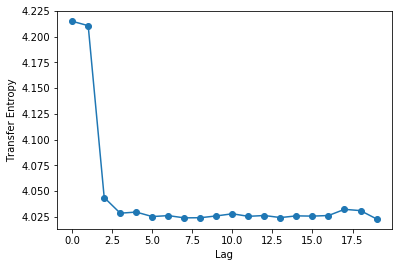

array([4.21502995, 4.21074163, 4.0439019 , 4.0286981 , 4.02978268,
       4.02541446, 4.02635174, 4.02416702, 4.02429724, 4.02603638,
       4.02811847, 4.02564825, 4.02644442, 4.02444555, 4.02609179,
       4.02586532, 4.02642013, 4.0324405 , 4.03119859, 4.02313958])

In [31]:
analyser(task,weather,20, 1000, name  = 'taskgivenweather.pdf')

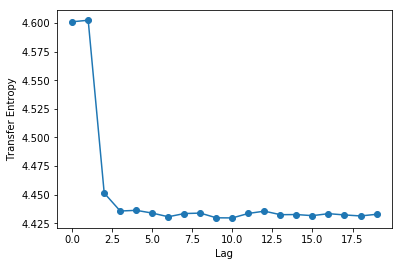

array([4.60114595, 4.60248878, 4.45137546, 4.43566838, 4.43625847,
       4.43385505, 4.43064157, 4.43344822, 4.43384572, 4.42972531,
       4.42963255, 4.43354614, 4.43554642, 4.4324541 , 4.43257303,
       4.4316146 , 4.43335263, 4.43224008, 4.43134946, 4.43279454])

In [32]:
analyser(weather,task,20, 1000, name  = 'weathergiventask.pdf')

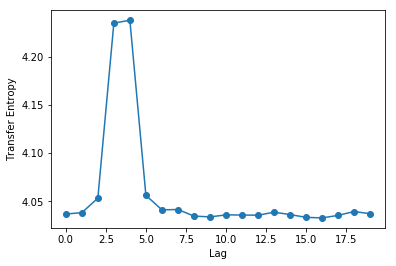

array([4.03665973, 4.0380498 , 4.05306207, 4.23509101, 4.23808356,
       4.05611217, 4.04098339, 4.04133097, 4.03452367, 4.03363275,
       4.03575892, 4.03559587, 4.03542227, 4.03852808, 4.03609473,
       4.03318708, 4.0325958 , 4.03523788, 4.03926189, 4.03694749])

In [33]:
analyser(task_lag3,weather_lag3,20, 1000, name  = 'taskgivenweatherlag3.pdf')

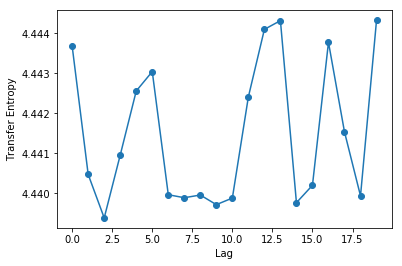

array([4.44368127, 4.44047519, 4.43938946, 4.44096008, 4.4425621 ,
       4.44304671, 4.43996911, 4.43989426, 4.43996172, 4.43972104,
       4.43988595, 4.44241531, 4.44410241, 4.4443202 , 4.43976987,
       4.44020511, 4.4437793 , 4.441539  , 4.43993963, 4.44433017])

In [34]:
analyser(weather_lag3,task_lag3,20, 1000, name  = 'weathergiventasklag3.pdf')

#### A random sequence

In [ ]:
def random_data(steps =200,intf =5):
    X = [np.random.randint(0,intf) for i in range(steps)]
    Y = [np.random.randint(0,intf) for i in range(steps)]
    return X,Y
RandX,RandY = random_data(20000,10)

In [ ]:
analyser(RandX,RandY,200, 1000, name  = 'random.pdf')

#### Lorenz differential equation system

In [35]:
rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0

def f(state, t):
    x, y, z = state  # unpack the state vector
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # derivatives

state0 = [1.0, 1.0, 1.0]
t = np.arange(0.0, 40.0, 0.01)

states = odeint(f, state0, t)
StateX = states[:,0]
StateY = states[:,1]
StateZ = states[:,2]

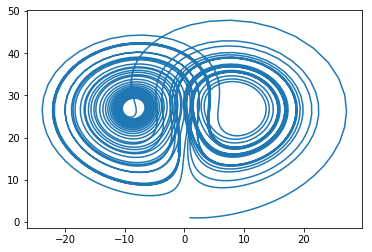

In [36]:
plt.plot(StateY,StateZ)
plt.show()

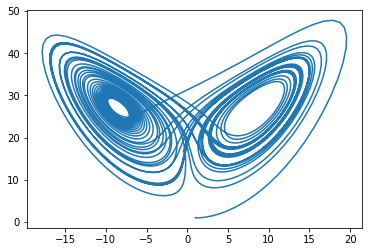

In [37]:
plt.plot(StateX,StateZ)
plt.show()

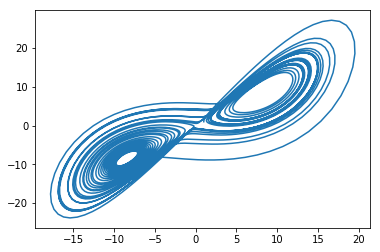

In [38]:
plt.plot(StateX,StateY)
plt.show()

My code is only for discete data but the Lorenz system is continuous. To deal with that, I make the data discrete by converting the floats to integers. (Don't judge me)

It isn't a terrible thing to do if you look below.

In [ ]:
plt.plot(StateX.astype(int),StateY.astype(int))
plt.show()

In [ ]:
analyzer(StateY,StateZ, name  = 'LorenzYgivenZ.pdf')

In [ ]:
analyzer(StateZ,StateY, name  = 'LorenzZgivenY.pdf')

We discretized a dynamical system in the previous example. So, why not do discrete dynamics from the start?

#### Nicholson-Bailey model

Host(H) - Parasite(P) dynamics

$H_{t+1} = kH_te^{-aP_t}$


$P_{t+1} = cH_t(1-e^{-aP_t})$

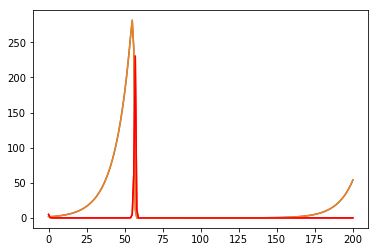

In [16]:
def NBmodel(IC,steps =200):
    c = 1
    a = .05
    k =1.1
    H = np.zeros(steps+1)
    P = np.zeros(steps+1)
    H[0]= IC[0]
    P[0]= IC[1]
    for i in range(steps):
        H[i+1]= k*H[i]*np.exp(-a*P[i])
        P[i+1]= c*H[i]*(1-np.exp(-a*P[i]))
    return H,P
H,P = NBmodel([2,5])
plt.plot(H)
plt.plot(P,'r')
plt.show()    

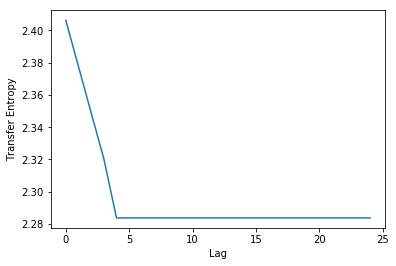

array([2.40631767, 2.37762173, 2.34898485, 2.32040766, 2.28378376,
       2.28378376, 2.28378376, 2.28378376, 2.28378376, 2.28378376,
       2.28378376, 2.28378376, 2.28378376, 2.28378376, 2.28378376,
       2.28378376, 2.28378376, 2.28378376, 2.28378376, 2.28378376,
       2.28378376, 2.28378376, 2.28378376, 2.28378376, 2.28378376])

In [17]:
analyser(H.astype(int),P.astype(int),maxlag =25,startid = 30,  name = 'HgivenP.pdf')

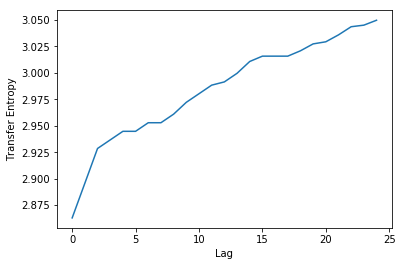

array([2.86293959, 2.89568903, 2.92849694, 2.93660393, 2.94471091,
       2.94471091, 2.95281789, 2.95281789, 2.96092488, 2.97209179,
       2.98019878, 2.98830576, 2.99136569, 2.99947268, 3.01063959,
       3.01568665, 3.01568665, 3.01568665, 3.0207337 , 3.02725837,
       3.02924549, 3.03577016, 3.04347234, 3.04494995, 3.0495922 ])

In [18]:
analyser(P.astype(int),H.astype(int),maxlag =25,startid = 30,  name = 'PgivenH.pdf')

### Modified NB model

We modify the previous model so that P doesnt have any influence on H

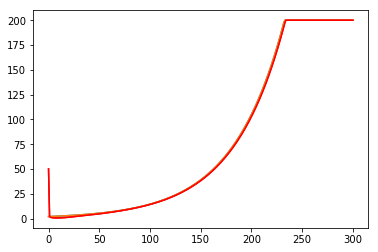

In [20]:
def mNBmodel(IC,steps =300):
    c = 1
    a = .5
    k =1.02
    H = np.zeros(steps+1)
    P = np.zeros(steps+1)
    H[0]= IC[0]
    P[0]= IC[1]
    for i in range(steps):
        H[i+1]= k*H[i]
        P[i+1]= c*H[i]*(1-np.exp(-a*P[i]))
    return H,P
mH,mP = mNBmodel([2,50])
mH[mH>200]=200
mP[mP>200]=200
plt.plot(mH)
plt.plot(mP,'r')
plt.show()

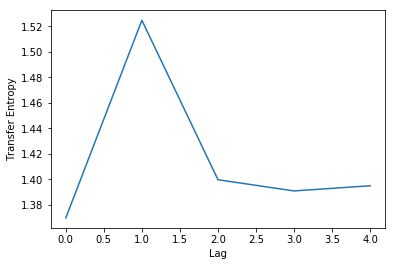

array([1.36988104, 1.52472338, 1.39979819, 1.3910087 , 1.39507276])

In [21]:
analyser(mP.astype(int),mH.astype(int),maxlag= 9,startid =10,name = 'mPgivenmH.pdf')

In [ ]:
analyser(mH.astype(int),mP.astype(int),maxlag= 9,startid =10,name = 'mHgivenmP.pdf')

#### Lotka Volterra Dynamics

In [ ]:
def LVmodel(IC, steps =2000, params = [4.1,1,2.93,0.2]):
    a,b,d,g =params
    x = np.zeros(steps+1)
    y = np.zeros(steps+1)
    x[0]= IC[0]
    y[0]= IC[1]
    for i in range(steps):
        x[i+1]= a*x[i]*(1-x[i]) -b*x[i]*y[i]
        y[i+1]= d*x[i]*y[i]-g*y[i]
    return x,y
H,P = LVmodel([0.3,0.7], params = [4.1,1,2.93,0.2])
plt.plot(H,P)

In [ ]:
lvX = (100*H).astype(int)
lvY = (100*P).astype(int)

In [ ]:
plt.plot(lvX[1000:1100])
plt.plot(lvY[1000:1100])

In [ ]:
analyser(lvY,lvX,50,200)

In [ ]:
analyser(lvY,lvX,maxlag = 50,startid = 200)

In [ ]:
analyser(lvY,lvX,maxlag = 50,startid = 200)